In [95]:
import sys
if "/rhome/naotok/.local/lib/python3.10/site-packages" in sys.path:
    sys.path.remove("/rhome/naotok/.local/lib/python3.10/site-packages")

In [96]:
# import library
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 1000)
import scanpy as sc
import anndata as ad
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import scrublet as scr

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.8
scanpy      1.9.5
-----
PIL                 9.2.0
annoy               NA
array_api_compat    1.7.1
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.1
cloudpickle         2.2.0
colorama            0.4.5
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.9.2
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.5.1
entrypoints         0.4
exceptiongroup      1.2.2
executing           1.1.1
fontTools           4.37.4
fsspec              2022.8.2
google              NA
h5py                3.7.0
harmonypy           NA
hypergeom_ufunc     NA
igraph              0.10.8
ipykernel           6.16.0
ipython_genutils    0.2.0
ipywidgets          8.0.2
jedi                0.18.1
jinja2              3.1.2
joblib              1.2.0
jupyter_server      1.21.0

In [ ]:
%matplotlib inline
# Set workdir
workdir = "/rhome/naotok/bigdata/Aldh1l1Cre/kb-nac"
results_file = workdir + "/scanpy/results.h5ad"
sc.settings.figdir = workdir + "/scanpy/figures"
sc.settings.cachedir = workdir + "/scanpy/cache"

# Load adata

In [98]:
samples = ["WT", "KO"]

WT
filtered out 43 cells that have less than 200 genes expressed
filtered out 6771 genes that are detected in less than 1 cells


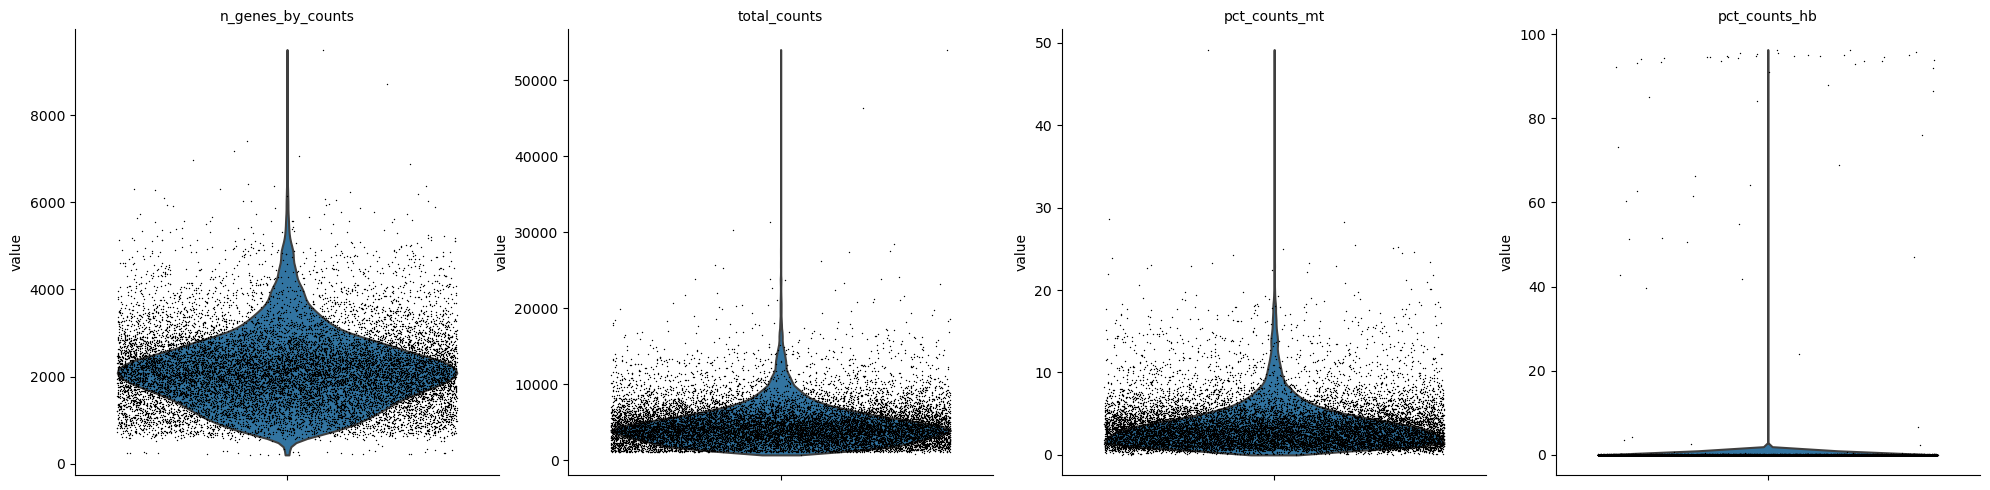

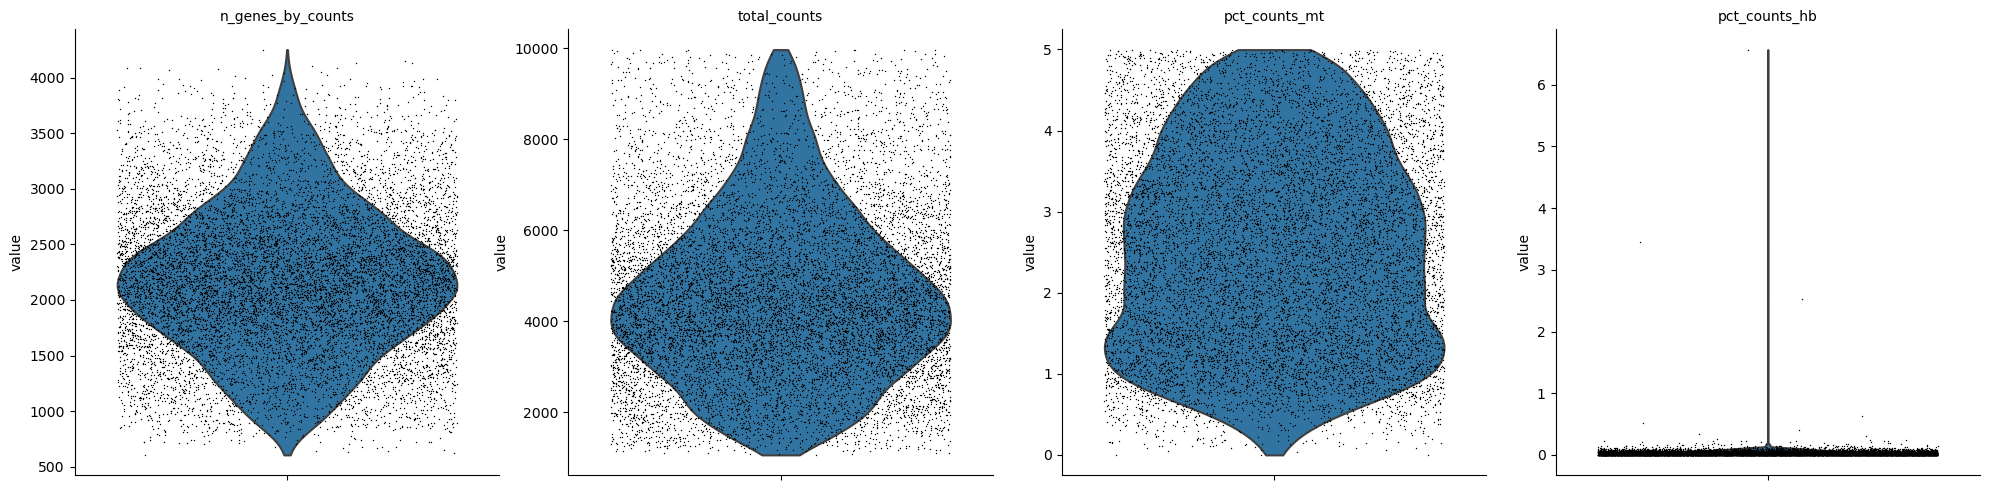

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 58.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.5%
Elapsed time: 12.3 seconds


/scratch/naotok/7841770/ipykernel_2899869/3289930099.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Doublet'] = scrub.predicted_doublets_


KO
filtered out 10 cells that have less than 200 genes expressed
filtered out 6740 genes that are detected in less than 1 cells


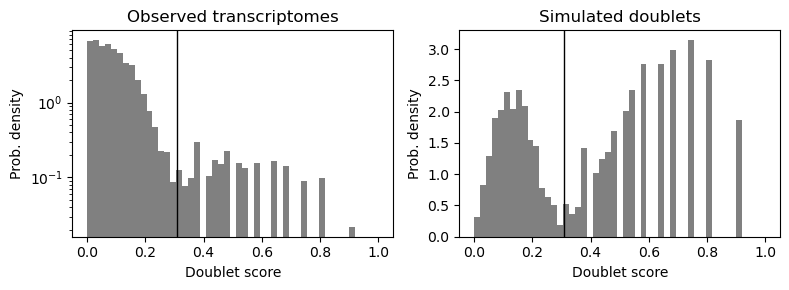

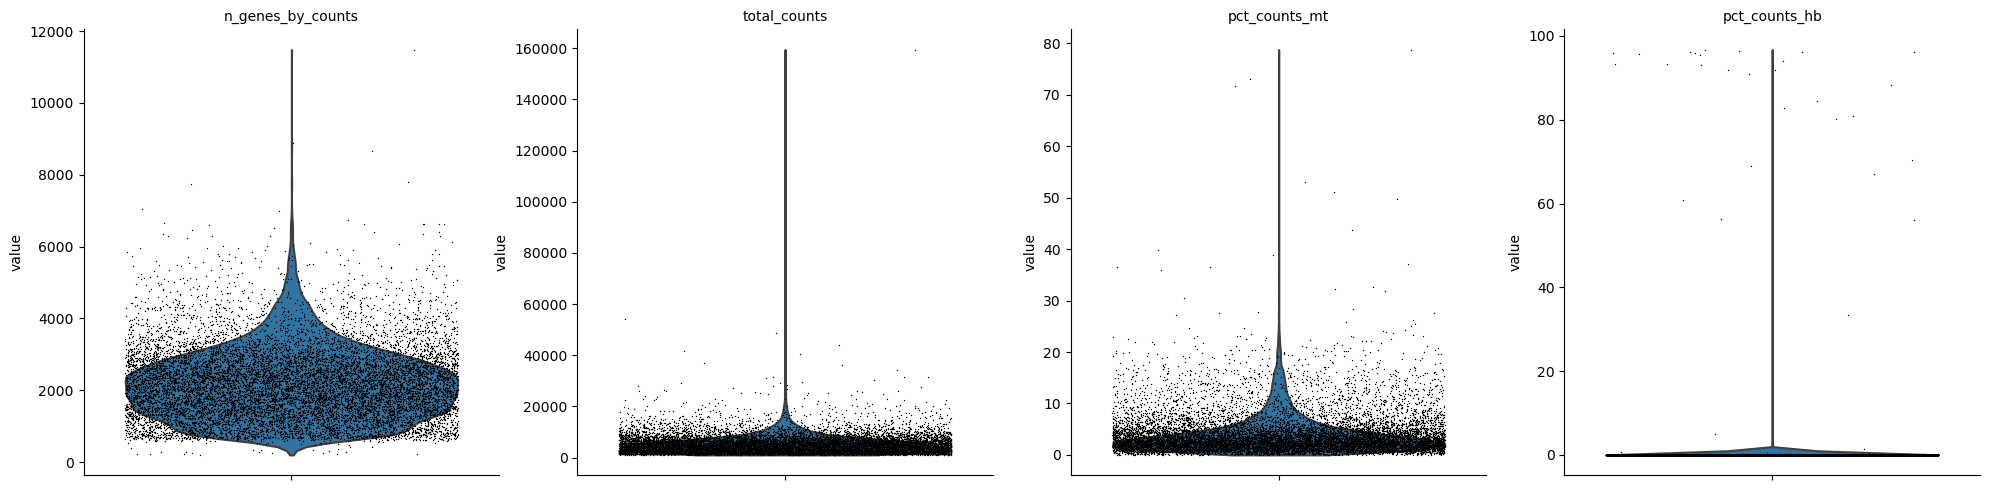

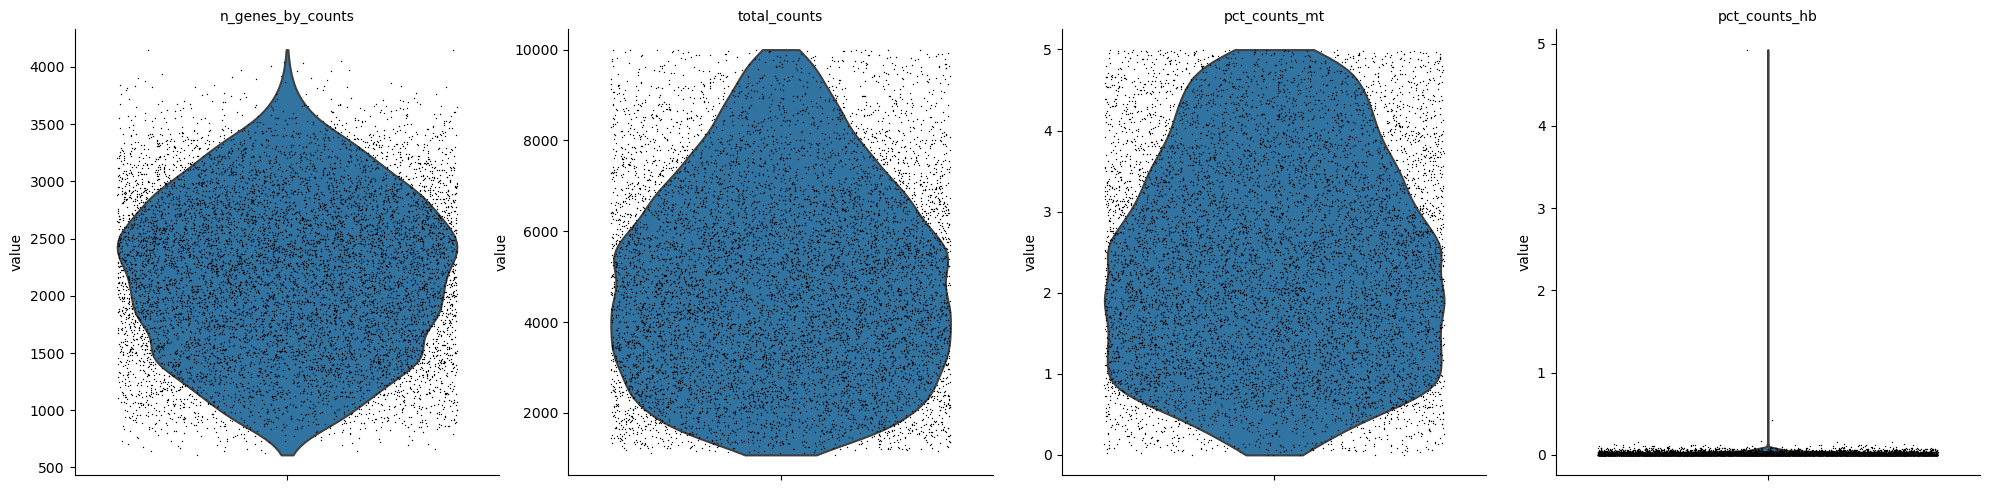

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 58.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 8.4 seconds


/scratch/naotok/7841770/ipykernel_2899869/3289930099.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Doublet'] = scrub.predicted_doublets_


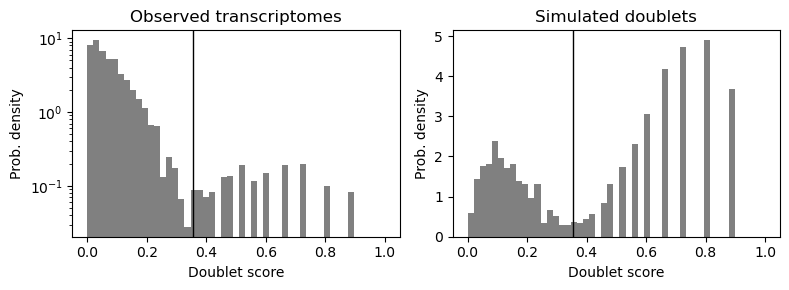

In [99]:
# Load adata
adata_list = []
for i in range(len(samples)):
    print(samples[i])
    adata = ad.read_h5ad(workdir + "/kb/" + str(samples[i]) + "/counts_filtered/adata.h5ad")
    adata.X = adata.layers["ambiguous"] + adata.layers["mature"] + adata.layers["nascent"]
    # Filter out cells expressing <200 genes
    sc.pp.filter_cells(adata, min_genes = 200)
    # Filter out genes expressed in only <2 cell
    sc.pp.filter_genes(adata, min_cells = 1)
   # mitochondrial genes, "MT-" for human, "mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "hb"], inplace=True, log1p=True
    )
    # Violin plot
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb"],
        jitter = 0.4,
        multi_panel = True,
        save = False
    )
    # Remove cells that have too many mitochondrial genes expressed or too many total counts or too small total counts 
    adata = adata[adata.obs.total_counts < 10000, :] # too many total counts
    adata = adata[adata.obs.total_counts > 1000] # too small counts
    adata = adata[adata.obs.pct_counts_mt < 5, :] # too many mitochondrial genes expressed
    adata = adata[adata.obs.pct_counts_hb < 10, :] # too many hemoglobin genes expressed
    # Violin plot
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb"],
        jitter = 0.4,
        multi_panel = True,
        save = False
    )
    # Doublet detection
    counts_matrix = adata.X
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_cells=2,
        min_gene_variability_pctl=85,
        n_prin_comps=40
    )
    scrub.plot_histogram()
    adata.obs['Doublet'] = scrub.predicted_doublets_
    adata.obs['Doublet Score'] = scrub.doublet_scores_obs_
    adata_list += [adata]

In [100]:
# Concatenate
adata = adata_list[0].concatenate(adata_list[1:], batch_categories = samples)

/scratch/naotok/7841770/ipykernel_2899869/2518100128.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_categories = samples)


In [101]:
adata.obs.head()

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,Doublet,Doublet Score,batch
barcode,,,,,,,,,,,,,,,,,,
AAACCCAAGCTCGTGC-WT,2239,2239,7.714231,4671.0,8.449343,28.195247,34.789124,43.245558,58.274459,208.0,5.342334,4.453008,4.0,1.609438,0.085635,False,0.188953,WT
AAACCCAAGGATTCCT-WT,1981,1981,7.591862,3860.0,8.258681,23.367876,30.336788,39.300518,57.383420,41.0,3.737670,1.062176,2.0,1.098612,0.051813,False,0.028777,WT
AAACCCACAAATCAAG-WT,2533,2533,7.837554,5723.0,8.652423,25.790669,32.395597,41.149747,56.980605,58.0,4.077537,1.013454,2.0,1.098612,0.034947,False,0.054521,WT
AAACCCACACTGCTTC-WT,3516,3516,8.165364,8796.0,9.082166,27.535243,33.651660,40.961801,54.149613,290.0,5.673323,3.296953,5.0,1.791759,0.056844,False,0.052016,WT
AAACCCAGTAACGGTG-WT,2665,2665,7.888335,5412.0,8.596559,17.239468,23.872875,32.945307,50.757576,66.0,4.204693,1.219512,1.0,0.693147,0.018477,False,0.033623,WT


In [102]:
# Check structure
print("Total number of cells: " + str(adata.obs.count()[0]))

Total number of cells: 20237


In [103]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [104]:
# Logarithmize the data (natural log (x+1))
sc.pp.log1p(adata)

In [105]:
# Highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
# This saves the original set of genes 
adata.raw = adata
# Saving count data
adata.layers["counts"] = adata.X.copy()

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


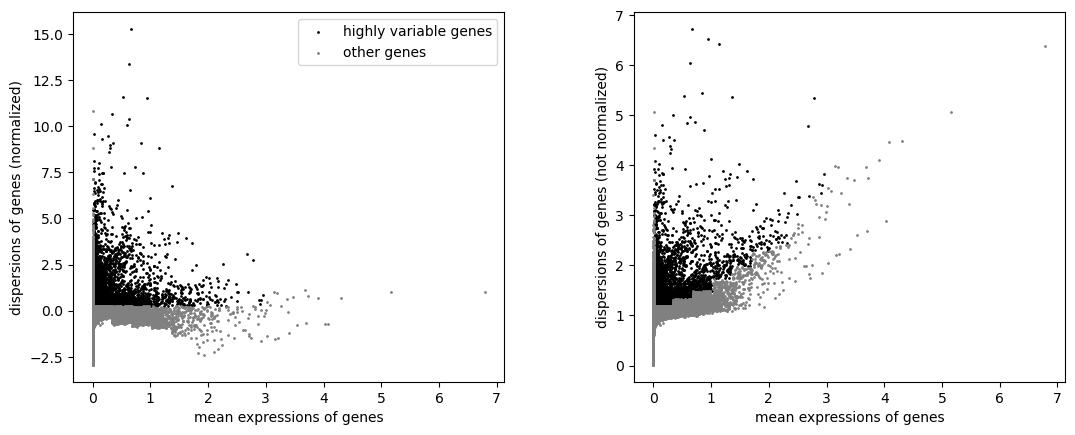

In [106]:
sc.pl.highly_variable_genes(adata)

In [107]:
adata = adata[:, adata.var.highly_variable]

In [108]:
adata.obs.head()

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,Doublet,Doublet Score,batch
barcode,,,,,,,,,,,,,,,,,,
AAACCCAAGCTCGTGC-WT,2239,2239,7.714231,4671.0,8.449343,28.195247,34.789124,43.245558,58.274459,208.0,5.342334,4.453008,4.0,1.609438,0.085635,False,0.188953,WT
AAACCCAAGGATTCCT-WT,1981,1981,7.591862,3860.0,8.258681,23.367876,30.336788,39.300518,57.383420,41.0,3.737670,1.062176,2.0,1.098612,0.051813,False,0.028777,WT
AAACCCACAAATCAAG-WT,2533,2533,7.837554,5723.0,8.652423,25.790669,32.395597,41.149747,56.980605,58.0,4.077537,1.013454,2.0,1.098612,0.034947,False,0.054521,WT
AAACCCACACTGCTTC-WT,3516,3516,8.165364,8796.0,9.082166,27.535243,33.651660,40.961801,54.149613,290.0,5.673323,3.296953,5.0,1.791759,0.056844,False,0.052016,WT
AAACCCAGTAACGGTG-WT,2665,2665,7.888335,5412.0,8.596559,17.239468,23.872875,32.945307,50.757576,66.0,4.204693,1.219512,1.0,0.693147,0.018477,False,0.033623,WT


In [109]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(
    adata,
    ['total_counts', 'pct_counts_mt']
)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:43)


In [110]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

# Dimentionality reduction

In [111]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


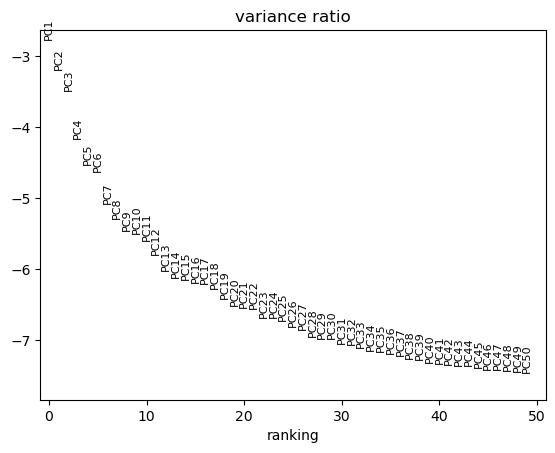

In [112]:
sc.pl.pca_variance_ratio(adata, n_pcs = 50, log = True)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


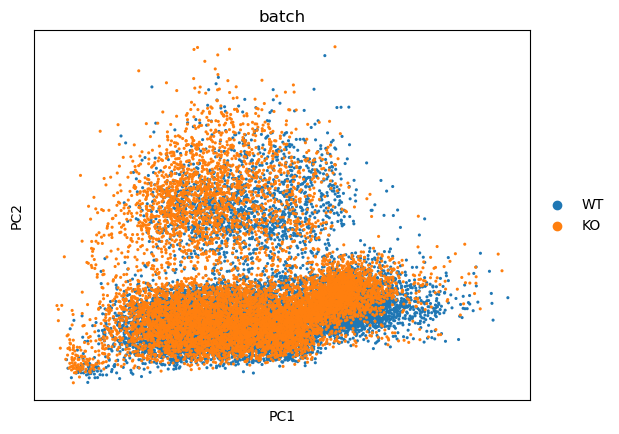

In [113]:
sc.pl.pca(
    adata,
    color = ["batch"],
    ncols = 1,
    size = 20,
    save = True
)

# Nearest neighbor graph constuction and visualization

In [114]:
sc.pp.neighbors(adata,  n_neighbors=15)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [115]:
for res in [0.02, 0.5, 1, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.02', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 25 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 42 clusters and added
    'leiden_res_2.00', the cluster labels (adata.obs, categorical) (0:00:02)


In [116]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata.shape[0])))

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


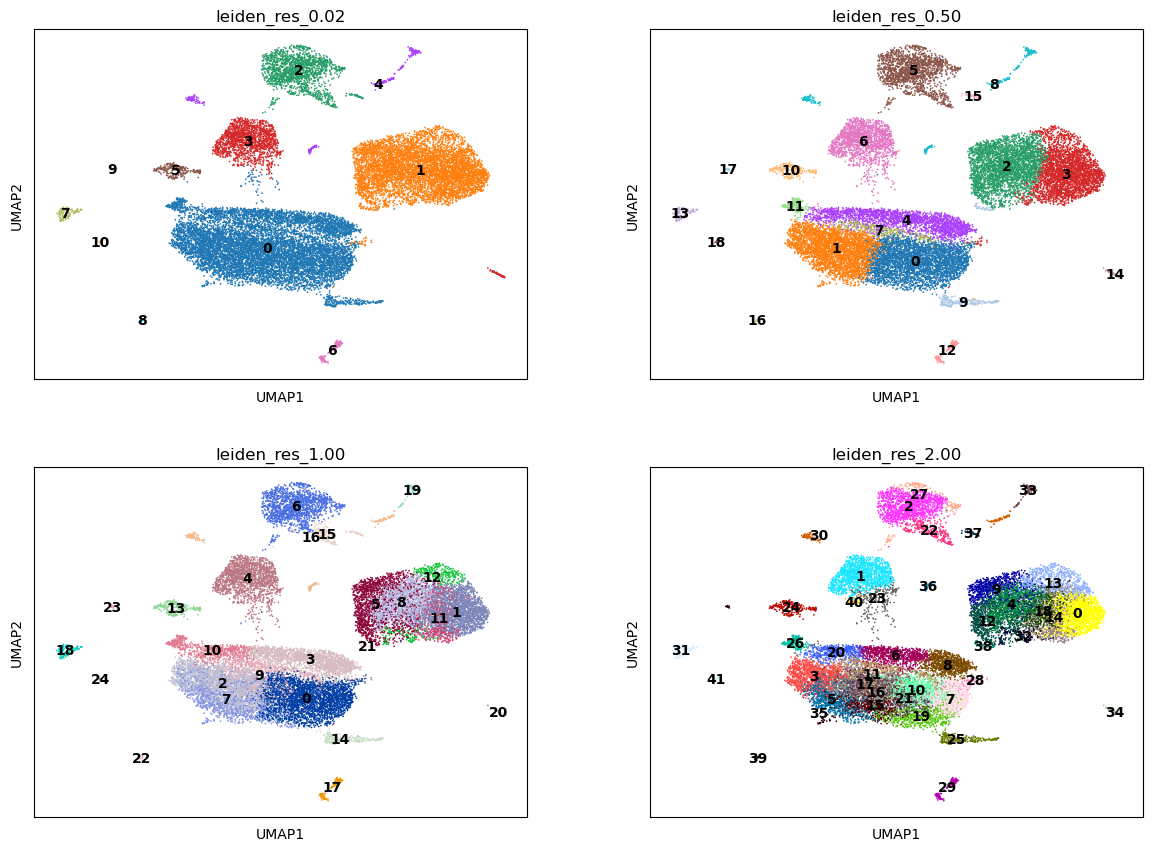

In [117]:
sc.pl.umap(
    adata[random_indices, :],
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols = 2,
    save = "_leiden_res_"
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


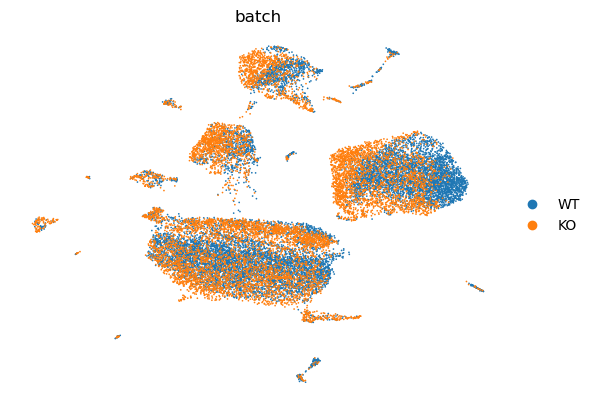

In [118]:
# UMAP (batch)
sc.pl.umap(
    adata,
    color = ['batch'],
    frameon = False,
    save = "_batch"
)

# Batch effect correction by Harmony

In [119]:
sc.external.pp.harmony_integrate(adata, 'batch')
adata_harmony = adata.copy()
adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_pca_harmony']

2024-10-14 14:33:17,157 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-14 14:33:24,725 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-14 14:33:24,776 - harmonypy - INFO - Iteration 1 of 10
2024-10-14 14:33:27,463 - harmonypy - INFO - Iteration 2 of 10
2024-10-14 14:33:30,123 - harmonypy - INFO - Iteration 3 of 10
2024-10-14 14:33:32,794 - harmonypy - INFO - Iteration 4 of 10
2024-10-14 14:33:35,410 - harmonypy - INFO - Iteration 5 of 10
2024-10-14 14:33:37,902 - harmonypy - INFO - Iteration 6 of 10
2024-10-14 14:33:38,968 - harmonypy - INFO - Iteration 7 of 10
2024-10-14 14:33:39,962 - harmonypy - INFO - Iteration 8 of 10
2024-10-14 14:33:41,025 - harmonypy - INFO - Iteration 9 of 10
2024-10-14 14:33:42,089 - harmonypy - INFO - Iteration 10 of 10
2024-10-14 14:33:43,152 - harmonypy - INFO - Converged after 10 iterations


In [120]:
sc.pp.neighbors(adata_harmony,  n_neighbors=15)
sc.tl.umap(adata_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [121]:
for res in [0.02, 0.5, 1, 2.0]:
    sc.tl.leiden(
        adata_harmony, key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_res_0.02', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden_res_1.00', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 40 clusters and added
    'leiden_res_2.00', the cluster labels (adata.obs, categorical) (0:00:03)


In [122]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata_harmony.shape[0])))

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


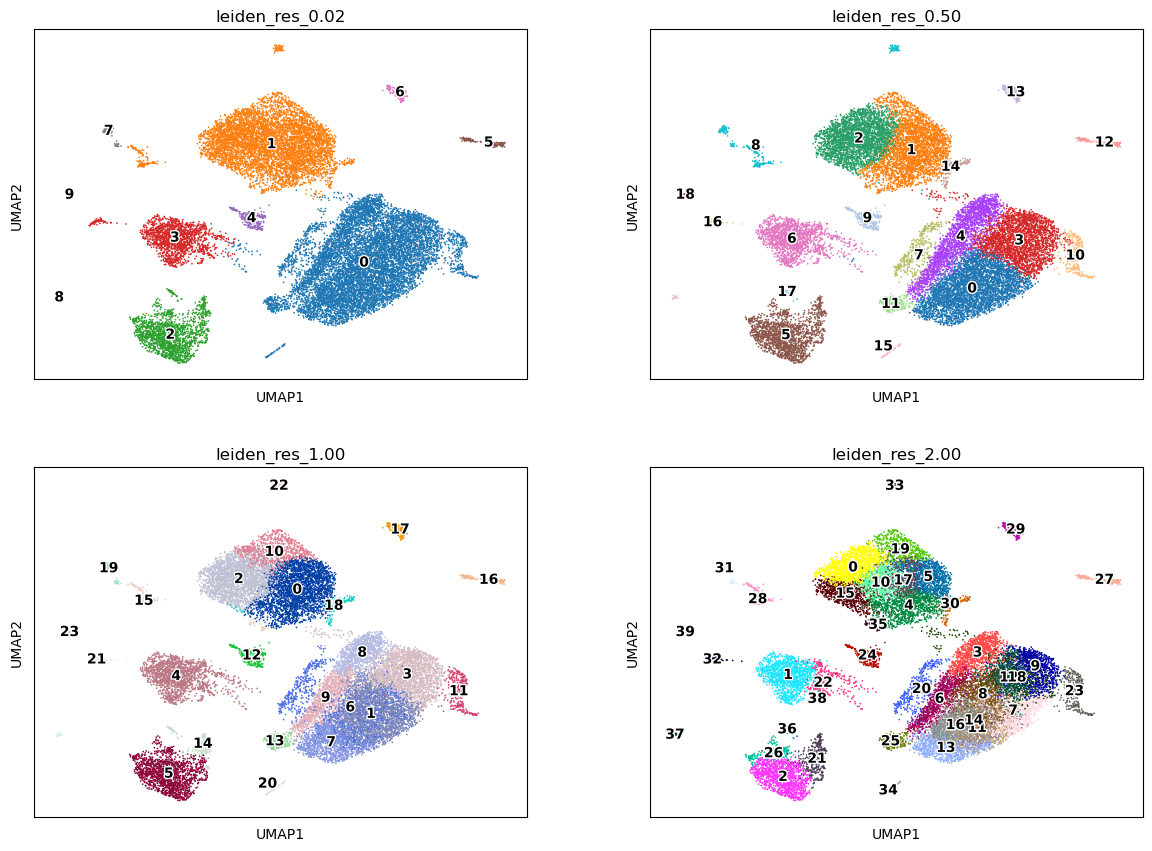

In [123]:
sc.pl.umap(
    adata_harmony[random_indices, :],
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols = 2,
    legend_fontoutline = 2,
    save = "_leiden_res_harmony_"
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


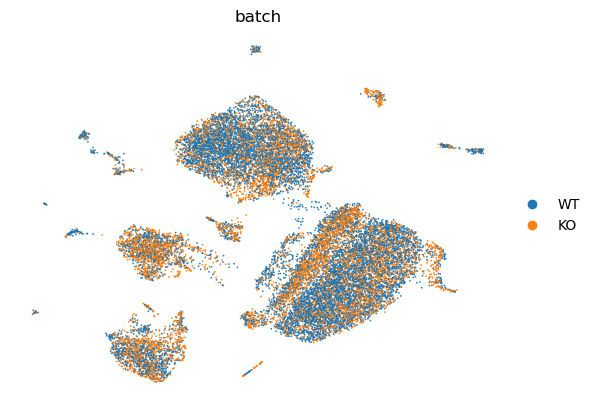

In [124]:
# UMAP (batch)
sc.pl.umap(
    adata_harmony[random_indices, :],
    color = ['batch'],
    frameon = False,
    save = "_batch_harmony"
)

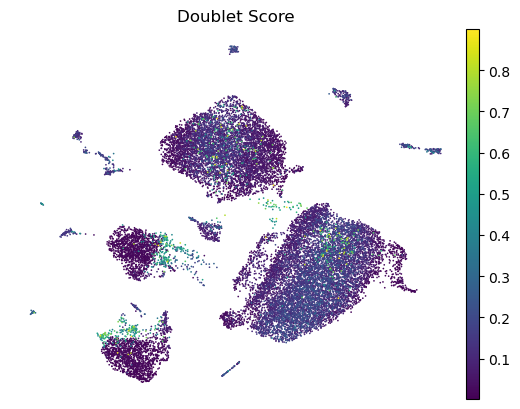

In [125]:
# Doublet score
sc.pl.umap(  
    adata_harmony,
    color = ['Doublet Score'],
    frameon = False,
    save = "_Doublet_Score_harmony"
)

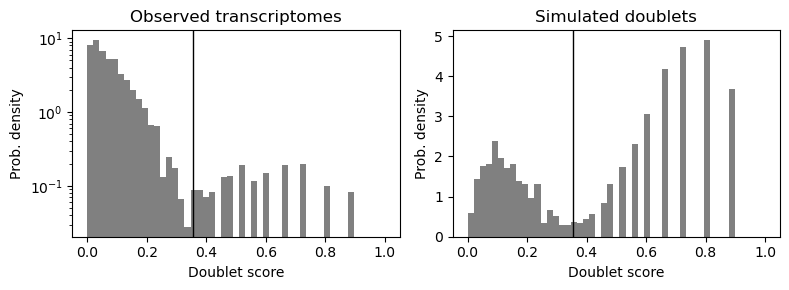

In [126]:
scrub.plot_histogram();

In [127]:
Doublet_dict = {True: "Yes", False: "No"}
adata_harmony.obs["Doublet or not"] = adata_harmony.obs["Doublet"].map(Doublet_dict)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


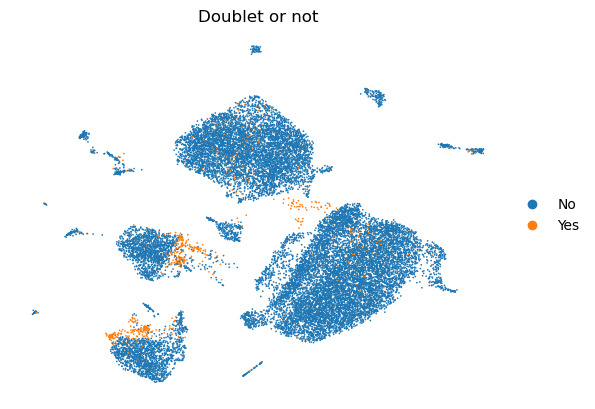

In [128]:
# Doublet
sc.pl.umap(
    adata_harmony,
    color = ['Doublet or not'],
    frameon = False,
    save = "_Doublet_harmony"
)

In [129]:
# Drop doublet
adata_harmony = adata_harmony[adata_harmony.obs.Doublet == False, :]

# Check Cre and TdTomato expression

In [130]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata_harmony.shape[0])))

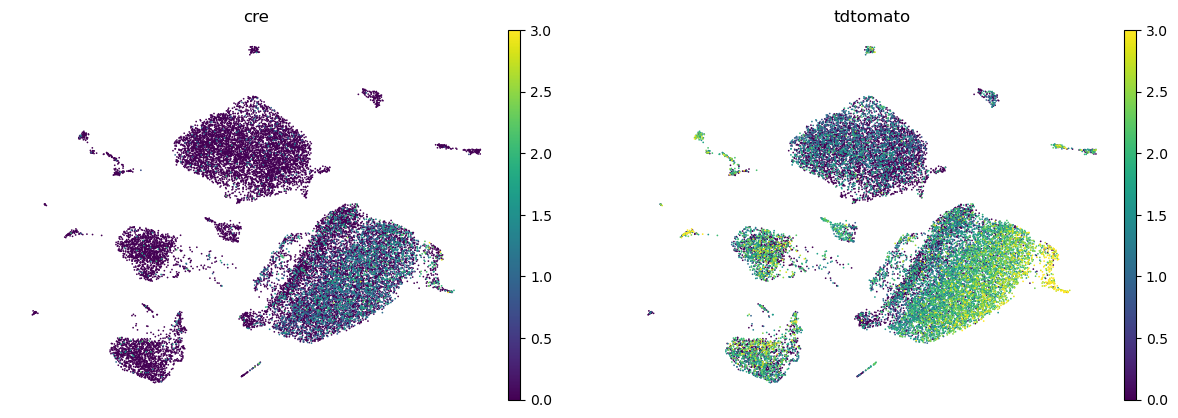

In [131]:
# UMAP (batch)
sc.pl.umap(
    adata_harmony[random_indices, :],
    color = ['cre', 'tdtomato'],
    frameon = False,
    vmax = 3
)

In [132]:
adata_harmony

View of AnnData object with n_obs × n_vars = 19445 × 3634
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Doublet', 'Doublet Score', 'batch', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00', 'Doublet or not'
    var: 'mt', 'hb', 'n_cells-KO', 'n_cells_by_counts-KO', 'mean_counts-KO', 'log1p_mean_counts-KO', 'pct_dropout_by_counts-KO', 'total_counts-KO', 'log1p_total_counts-KO', 'n_cells-WT', 'n_cells_by_counts-WT', 'mean_counts-WT', 'log1p_mean_counts-WT', 'pct_dropout_by_counts-WT', 'total_counts-WT', 'log1p_total_counts-WT', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'batch_colors', 'neighbors'

In [133]:
# Save
adata_harmony.write(results_file)